<div>
<img align="right" src="pictures/Logo.png" width="200"/>
</div>

# Persistent topological spectra from the quantum algorithm

Kathrin König (kathrin.koenig@iaf.fraunhofer.de), Andreas Woitzik (andreas.woitzik@physik.uni-freiburg.de), Eric Brunner (eric.brunner@physik.uni-freiburg.de)

In [1]:
import numpy as np
import qtda_module as qtda
from qiskit.visualization import plot_histogram

In this notebook we explain the persistent topological analysis, in particular how topological spectra can be obtained on different scales from a data filtration, and how to extract Betti numbers from them. For this a filtration of simplicial complexes is generated from the data cloud. This filtration encodes topological and geometric signatures to understand the shape of the data.

To generate the data filtration, we build upon the Python-library GUDHI (https://github.com/GUDHI) for classical topological data analysis. The data can either be supplied by data points in euclidean space, or as an abstract distance matrix (containing all pairwise distances of the points) in a general metric space.

## Data filtration

We consider a square of four points:

<div>
<img src="pictures/SquareOf4Points.png" width="300"/>
</div>

In [2]:
import pandas as pd
import io

# Small bit of network data
csv_data = """
timestamp,src_ip,dst_ip,duration,packets_count,total_payload_bytes,bytes_rate,syn_flag_counts,label
2018-02-23 12:03:53.127569,195.222.75.1,172.31.65.40,4.502483129501343,19.0,3091,686.5100681326336,2.0,Benign
2018-02-23 12:03:53.133652,172.31.65.71,54.148.143.136,61.56716012954712,30.0,4176,67.82836809774936,2.0,Benign
2018-02-23 12:03:53.134750,172.31.64.116,54.165.178.227,0.0,1.0,0,0.0,0.0,Benign
2018-02-23 12:03:53.139342,213.202.230.206,172.31.64.119,90.11222386360168,24.0,3668,40.70479944598932,2.0,Benign
"""

df = pd.read_csv(io.StringIO(csv_data))

# Select relevant columns and build the point data array
point_data = df[["duration", "packets_count"]].to_numpy()

print("Point data:")
print(point_data)

Point data:
[[ 4.50248313 19.        ]
 [61.56716013 30.        ]
 [ 0.          1.        ]
 [90.11222386 24.        ]]


In [2]:
point_data = np.array([
    [0.,0.],
    [1.,0.],
    [1.,1.],
    [0.,1.],
    ])

# alternatively a distance matrix (here generated from the point data for exemplification)
# can be used
from scipy.spatial import distance_matrix
dist_mat = distance_matrix(point_data, point_data)

dm = distance_matrix(point_data, point_data)
max_edge_length = np.percentile(dm[dm > 0], 75)

filtration = qtda.DataFiltration(
    data=point_data, 
#     distance_matrix=dist_mat, 
    max_dimension=3, 
    max_edge_length=2
    )

print(max_edge_length)

1.4142135623730951


A maximal dimension up to which simplices are considered and a maximal edge-length have to be given. This allows a more efficient generation of the filtration and is reasonable, since usually one is interested in topological features up to a given order.

The persistence diagram of the filtration can be plotted. From there it is seen, that on zeroth order several (four) features (connected components) appear at scale $\varepsilon = 0$, which die again at scale $\varepsilon = 1$. These are the four connected components (the individual data points) that connect to a single component at $\varepsilon = 1$. At this filtration scale, on first order the 1-dimensional hole in the square is born. This feature dies at $\varepsilon = \sqrt{2}$ when the diagonal vertices connect to build four 2-simplices filling the square.

/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:134: UserWarning: usetex mode requires dvipng.
  warnings.warn("usetex mode requires dvipng.")


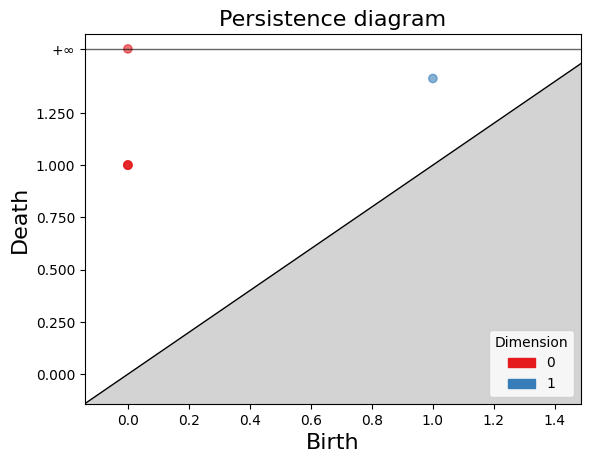

In [3]:
filtration.plot_persistence_diagram()

## Quantum analysis of topological spectra

Next, the quantum algorithm, provided by `qtda.Q_persistent_top_spectra`, is employed to calculate these topological features on the different filtration scales. For the algorithm one has to specify the maximal dimension up to which topological features should be analyzed. In our example of four vertices, only $k$-simplices for $k=0,1,2,3$ are possible. Further, a maximal egde-length has to be specified, which we set to 2 to allow for all possible connections between the data points. Non-trivial changes in the topology occur at the three scales $\varepsilon = 0,1,\sqrt{2}$.

In [4]:
print(point_data.shape)


(4, 2)


In [8]:
shots = 1000
num_eval_qubits = 10
# epsilons = [0.1, 1.1, 1.5]

data = qtda.Q_persistent_top_spectra(
    data = point_data,
#     distance_matrix=distance_matrix, 
    max_dimension=3, 
    max_edge_length=max_edge_length, 
    num_eval_qubits=num_eval_qubits, 
    shots=shots)


Filtration scale:  0.0

Topological order:  0
Topological order:  1
calculation terminated because no simplex of dimension 1

Filtration scale:  1.0

Topological order:  0
Topological order:  1
Topological order:  2
calculation terminated because no simplex of dimension 2

Filtration scale:  1.4142135381698608

Topological order:  0
Topological order:  1
Topological order:  2
Topological order:  3


Below, the topological spectra (eigenvalues of the combinatorial laplacian $\Delta_k$ with dimension of corresponding eigenspace) are shown on all filtration scales $\varepsilon = 0,1,\sqrt{2}$ and orders $k=0,1$, since the topology in higher dimensions is trivial in the considerd example. The dimension of the Zero-eigenspace $\dim \text{Eig}_0(\Delta_0)$ (i.e. the kernel of $\Delta_k$) gives the number of holes, i.e. the Betti-number $\beta_k$, at this topological order. Note that on zeroth order, the number of connected components, i.e the number of 0-holes plus one, is $1 + \dim \text{Eig}_0(\Delta_0)$.

Further, the counting statistics of the QTDA-circuit is shown. Note that to determine the dimension of the Zero-eigenspaces $\text{Eig}_0(\Delta_k)$, a much lower numerical precision would be sufficient. Already with only five numerical evaluation qubits (of the phase estimation algorithm), the number of holes at different scales and topological orders is estimated very well.

In [5]:
# Pick an ε that isn’t exactly 1.0 or √2, but falls in between.
epsilons = [1.001]

data = qtda.Q_persistent_top_spectra(
    data=point_data,
    max_dimension=3,
    max_edge_length=1.001,
    num_eval_qubits=10,
    shots=shots,
    epsilons=[0.0, 1.001]
)
eigs = data.get_eigenvalues()
print("ε=0.0:", eigs[0.0][0])      # should be {0.0: 3.0}
print("ε=1.001:", eigs[1.001][0])  # should be {0.0: 3.0, 4.00…: …}




Filtration scale:  0.0

Topological order:  0
Topological order:  1
calculation terminated because no simplex of dimension 1

Filtration scale:  1.001

Topological order:  0
Topological order:  1
Topological order:  2
calculation terminated because no simplex of dimension 2
ε=0.0: {0.0: np.float64(2.8), 4.00453257114476: np.float64(1.128)}
ε=1.001: {0.0: 0, 2.00226628557238: np.float64(2.064), 4.00453257114476: np.float64(1.884)}




Filtration scale:  0.0

Topological order:  0
Number of holes:  3.068
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: np.float64(3.068), 4.00453257114476: np.float64(0.888)}


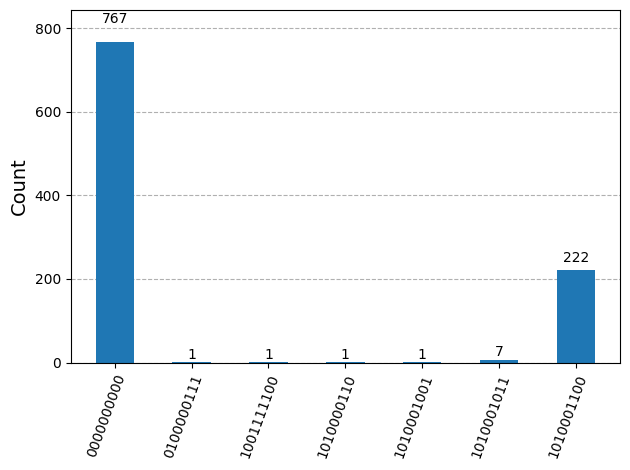



Filtration scale:  1.0

Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 2.00226628557238: np.float64(2.04), 4.00453257114476: np.float64(1.9)}


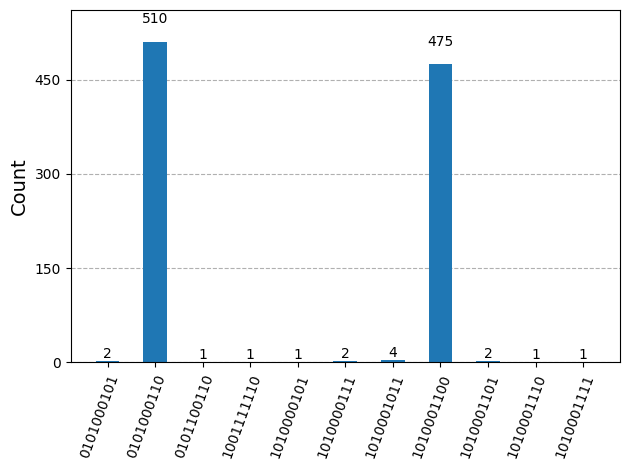


Topological order:  1
Number of holes:  0.916
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: np.float64(0.916), 4.00453257114476: np.float64(1.02), 2.00226628557238: np.float64(2.0)}


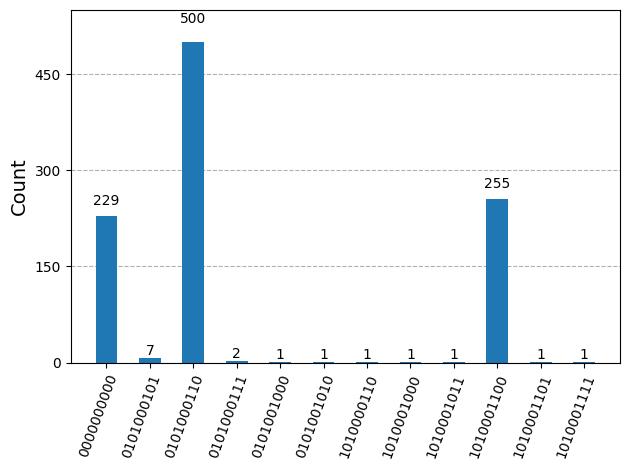



Filtration scale:  1.4142135

Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 4.00453257114476: np.float64(3.86)}


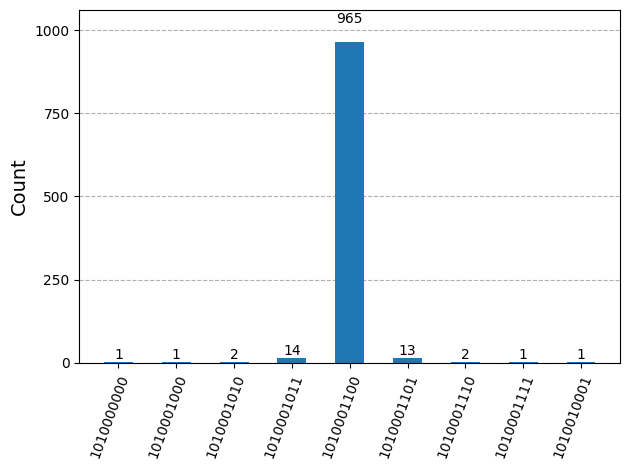


Topological order:  1
Number of holes:  0
Dimension of the k-simplex subspace:  6
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 4.00453257114476: np.float64(5.79)}


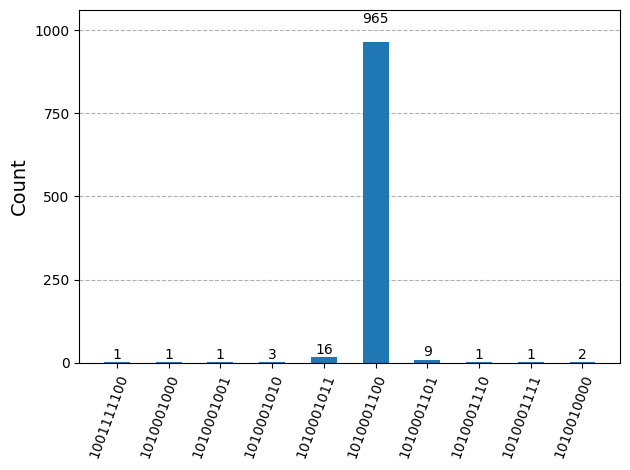


Topological order:  2
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 4.00453257114476: np.float64(3.848)}


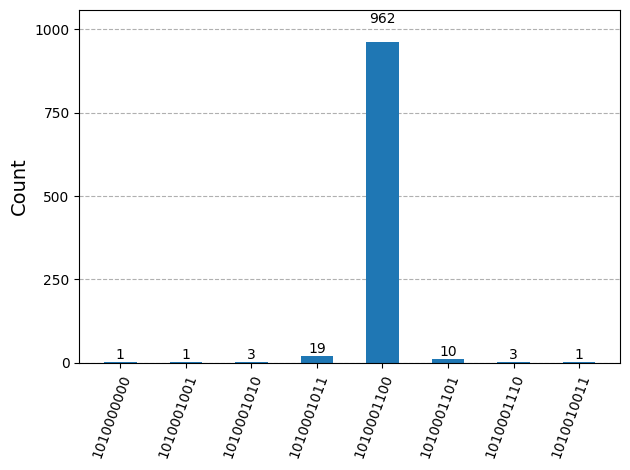


Topological order:  3
Number of holes:  0
Dimension of the k-simplex subspace:  1
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 4.00453257114476: np.float64(0.971)}


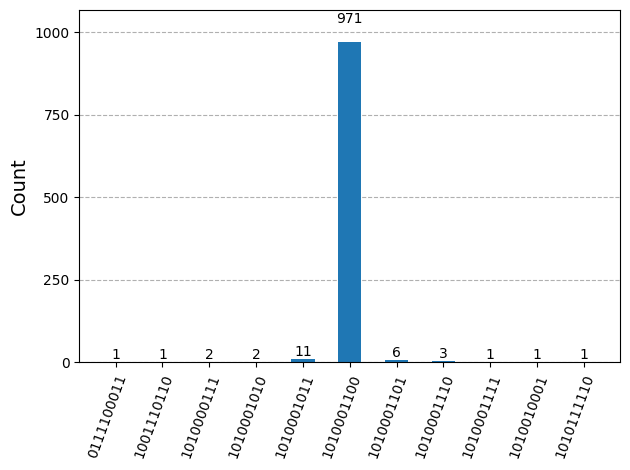

In [9]:
eigenvalue_dict = data.get_eigenvalues()

for eps in eigenvalue_dict.keys():
    print()
    print()
    print('Filtration scale: ', eps)
    for top_order in eigenvalue_dict[eps].keys():
        print()
        print('Topological order: ', top_order)
        print('Number of holes: ', eigenvalue_dict[eps][top_order][0.0])
        print('Dimension of the k-simplex subspace: ', len(data.state_dict[eps][top_order]))
        print('Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: ')
        print(eigenvalue_dict[eps][top_order])
        display(plot_histogram(data.get_counts()[eps][top_order]))

We see, that at $\varepsilon = 0$ we have $3+1 = 4$ connected components (i.e. three 0-dimensional holes between them), one for each of the data points. These connect to a single connected component at filtration scale $\varepsilon = 1$. Further, at this scale the 1-dimensional hole in the square is born, which terminates at $\varepsilon = \sqrt{2}$ when the inner of the square (the 2-simplices $[0,1,1,1],[1,0,1,1],[1,1,0,1]$ and $[1,1,1,0]$) is added.

Our quantum topological analysis is able to rediscover the same topological features and their persistence as observed in the persistence diagram above.

Further, the algorithm gives us direct access also to the other eigen-values, and the dimensions of the corresponding eigen-spaces, of the combinatorial Laplacian $\Delta_k$. Note that these dimensions always approximately sum up to the dimension of the full $k$-simplex subspace. This verifies the correct functioning of the algorithm to extract all eigenvalues of $\Delta_k$.

In [6]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}